               High      Low     Open    Close    Volume     Adj Close
Date                                                                  
2012-11-01  71300.0  68600.0  71300.0  70500.0  123448.0  48198.136719
2012-11-02  71500.0  69500.0  71400.0  70900.0   79563.0  48471.597656
2012-11-05  68000.0  64100.0  68000.0  65000.0  261263.0  44437.996094
2012-11-06  69000.0  65000.0  65300.0  67600.0  110421.0  46215.515625
2012-11-07  70600.0  68300.0  68700.0  70600.0   84814.0  48266.500000
...             ...      ...      ...      ...       ...           ...
2022-10-25  77400.0  76300.0  77400.0  77000.0   71652.0  77000.000000
2022-10-26  77400.0  76500.0  77300.0  77200.0   52262.0  77200.000000
2022-10-27  78600.0  77200.0  77600.0  78600.0   58647.0  78600.000000
2022-10-28  79300.0  77600.0  78200.0  79300.0   42433.0  79300.000000
2022-10-31  79900.0  78300.0  79800.0  79800.0   52412.0  79800.000000

[2455 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex:

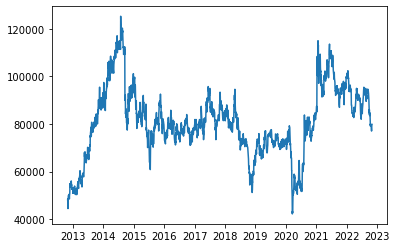

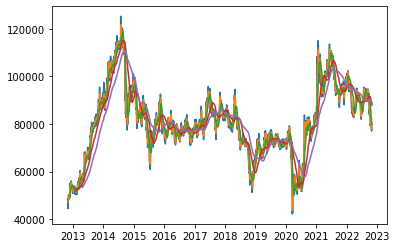

In [32]:
# pandas_datareader 패키지의 data 모듈을 임포트한 후 추가로 datetime이라는 모듈을 임포트.
# 아나콘다 프롬프트에서 conda install pandas-datareader
import pandas_datareader.data as web
# datetime은 파이썬에서 날짜를 쉽게 표현하는 데 사용하는 모듈
import datetime    
start = datetime.datetime(2012, 11, 1) 
end = datetime.datetime(2022, 10, 31) 
# DataReader 함수의 첫 번째 인자로는 조회할 종목에 대한 정보를 넣고, 
# 두 번째 인자로는 데이터를 가져올 소스(야후)에 대한 정보를 입력,
# 세 번째와 네 번째 인자에는 조회 기간의 시작일과 종료일을 입력
# ss = web.DataReader("005930.KS", "yahoo", start, end)
# 005387 현대차2우B
ss = web.DataReader("005387.KS", "yahoo", start, end)

# ss 바인딩 하고 있는 데이터 값 확인
print(ss)



#DataFrame에서 info매서드 호출
ss.info()

#matplotlib 패키지의 pyplot이라는 모듈을 사용
import matplotlib.pyplot as plt
#pyplot 모듈의 plot 함수, DataFrame에서 'Adj Close'라는 칼럼데이터를 넘김
plt.plot(ss['Adj Close'])
#그래프를 화면에 출력
plt.show()

# 이동평균법 적용을 위한 tail( ) 함수_뒤에서 5개데이터 확인
ss.tail()

# 5일치 평균내어 이동평균계산
ma5 = ss['Adj Close'].rolling(window=5).mean()
#ma5 객체 타입확인 _Series
type(ma5)
# tail 메서드를 사용해 뒤에서부터 10개의 값만 확인
ma5.tail(10)
# 이동평균법 적용을 위한 tail( ) 함수_뒤에서 5개데이터 한번 더 확인
ss.tail()
# 거래량이 0이었던 일자에는 False 값이, 그렇지 않은 일자에는 True 확인
ss['Volume'] != 0

# false 데이터 있으면 제거, new tail 함수 확인 
new_ss = ss[ss['Volume'] !=0]
new_ss.tail(5)

#공휴일 데이터가 제거된 DataFrame 객체가 준비됐으니 다시 5일 이동평균 값을 계산
ma5 = new_ss['Adj Close'].rolling(window=5).mean()
ma5.tail(10)

# 5일 주가이동평균 값을 좀 더 쉽게 관리하기 위해 DataFrame 객체의 새로운 칼럼으로 추가 "MA5"
new_ss.insert(len(new_ss.columns), "MA5", ma5)
new_ss.tail(5) 

# 20일, 60일, 120일 기준으로 이동평균 값 역시 DataFrame 객체의 칼럼으로 추가
ma20 = new_ss['Adj Close'].rolling(window=20).mean()
ma60 = new_ss['Adj Close'].rolling(window=60).mean()
ma120 = new_ss['Adj Close'].rolling(window=120).mean()
new_ss.insert(len(new_ss.columns), "MA20", ma20)
new_ss.insert(len(new_ss.columns), "MA60", ma60)
new_ss.insert(len(new_ss.columns), "MA120", ma120)

import matplotlib.pyplot as plt
# 수정 종가 그래프를 그리기 위해 label 인자에 'Adj Close'를 전달
plt.plot(new_ss.index, new_ss['Adj Close'], label="Adj Close")
# 5, 20, 60일 이동평균선 그래프
plt.plot(new_ss.index, new_ss['MA5'], label="MA5")
plt.plot(new_ss.index, new_ss['MA20'], label="MA20")
plt.plot(new_ss.index, new_ss['MA60'], label="MA60")
plt.plot(new_ss.index, new_ss['MA120'], label="MA120")
plt.show()

In [33]:
# ! pip install statsmodels
# ! pip install pmdarima
# ! pip install plotly
# ! pip install exchange_calendars

In [34]:
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

주가의 학습부분과 예측해볼 부분을 표시해봅니다.


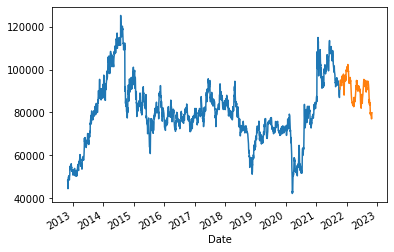

In [35]:
y_train = new_ss['Adj Close'][:int(0.9*len(new_ss))]
y_test = new_ss['Adj Close'][int(0.9*len(new_ss)):]
y_train.plot()
y_test.plot()
plt.show()

auto_arima 함수로 최적의 모형을 탐색해보겠습니다.  
위에서 9:1의 비율로 train과 test 데이터를 나누었습니다.  
train 데이터로 학습을 하고, test 데이터로 예측을 해봅니다.  

auto_arima에 주요한 옵션들을 설명하면 다음과 같습니다.

y: array 형태의 시계열 자료  
d (기본값 = none): 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음  
start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위 (start_p에서 max_p까지 찾는다!)  
start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위 (start_q에서 max_q까지 찾는다!)  
m (기본값 = 1): 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4이면 분기별, m=12면 월별, m=1이면 계절적 특징을 띠지 않는 데이터를 의미한다. m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정된다.  
seasonal (기본값 = True): 계절성 ARIMA 모형을 적합할지의 여부  
stepwise (기본값 = True): 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합한다.  
trace (기본값 = False): stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용한다.  

ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag을 의미하는 p, MA모형의 Lag을 의미하는 q, 차분(Diffrence)횟수를 의미하는 d 가 그것이다. 보통은 p, d, q의 순서로 쓴다.  
통상적으로 p + q < 2, p * q = 0 인 값들을 많이 사용한다.  
여기서 p * q = 0 이라 하면, 두 값중 하나는 0이라는 이야기이다.  
실제로 대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에, 이렇게 사용하는것이 더 잘 맞는다고 한다.

In [36]:

model = auto_arima(y_train, 
                   start_p=0, 
                   start_q=0, 
                   max_p=3, 
                   max_q=3, 
                   m=3, 
                   seasonal = False, # sarima(seasonal=True)
                   d=1,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True, 
                   stepwise=True)


c:\ProgramData\Anaconda3\envs\edupy38\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (3) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38775.815, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38776.374, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38776.235, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38774.114, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38776.718, Time=0.45 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.862 seconds


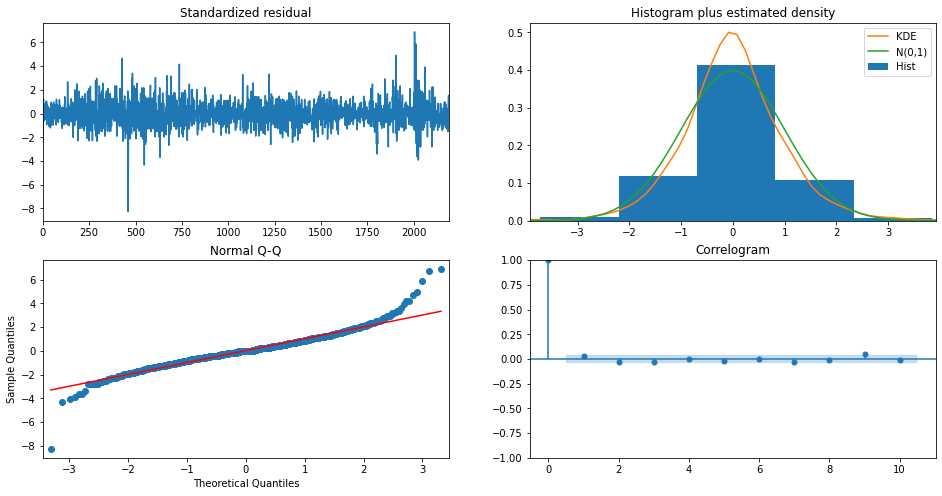

In [37]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [38]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [39]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

y_pred = pd.Series(y_pred, index=y_test.index)

c:\ProgramData\Anaconda3\envs\edupy38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



주식휴장일을 가져온다

In [40]:
import requests
import datetime
import pickle


def get_holidays(years):
    url = "https://open.krx.co.kr/contents/OPN/99/OPN99000001.jspx"
    # year = datetime.date.today().year			# 휴장일 검색 연도
    # year = 2023
    holidays = []
    for year in years:
        data = {"search_bas_yy": year,"gridTp": "KRX", "pagePath": "/contents/MKD/01/0110/01100305/MKD01100305.jsp",
        "code": 'VwN0qWxNxoQd3GptLiFi7VpQSV4Ewa+d2Su7DXPyhf9QzGrcwc/rwEcTS38k4e2df5Yx0Mfnbi2PWDHmer4lQzKMoOk5t9O8/DabZgelyz9UBc82a6GP7G4MABRDdIaJ7T+v79W6ON5hsRRGRUrUj69+eqY/BlbgIhBGzjGwqsT+CtNJN0ckkY/7efqYEaL7',
        'pageFirstCall': 'Y'}
        content_type = 'application/x-www-form-urlencoded; charset=UTF-8'
        response = requests.post(url=url, data=data, headers={'Content-Type': content_type})   
        resultJson = response.json()
        # print(response.json())
        holidays += [x['calnd_dd_dy'] for x in resultJson['block1']]
    return holidays

holidays = get_holidays([2022,2023])
print(f'휴장일 수 : {len(holidays)}, 날짜 : {holidays}')

# with open('marketHoliday.pickle', 'wb') as f:
# 	pickle.dump(holidays, f) #입력

휴장일 수 : 27, 날짜 : ['2022-01-31', '2022-02-01', '2022-02-02', '2022-03-01', '2022-03-09', '2022-05-05', '2022-06-01', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-12', '2022-10-03', '2022-10-10', '2022-12-30', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-01', '2023-05-05', '2023-06-06', '2023-08-15', '2023-09-28', '2023-09-29', '2023-10-03', '2023-10-09', '2023-12-25', '2023-12-29']


주식개장일을 가져온다

In [41]:
import exchange_calendars as ecals
import pandas as pd
import datetime

k = ecals.get_calendar("XKRX")
df = pd.DataFrame(k.schedule.loc["2022-11-01":"2023-10-31"])
# print(df)

date_list = []
for i in df['open']:
    date_list.append(i.strftime("%Y-%m-%d"))
   #테스트 print(i.strftime("%Y-%m-%d"))
   
# print(date_list)

In [42]:
y_pred2 = []
pred_upper2 = []
pred_lower2 = []

for new_ob in date_list:
    fc, conf = forecast_one_step()
    y_pred2.append(fc)
    pred_upper2.append(conf[1])
    pred_lower2.append(conf[0])

    ## 모형 업데이트 !!
    model.update(fc)
y_pred2= pd.Series(y_pred2, index=date_list)

In [43]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-10-12,90934.476562,91314.554688
2021-10-13,93595.046875,90934.476562
2021-10-14,94165.164062,93595.046875
2021-10-15,94735.281250,94165.164062
2021-10-18,95020.343750,94735.281250
...,...,...
2022-10-25,77000.000000,77200.000000
2022-10-26,77200.000000,77000.000000
2022-10-27,78600.000000,77200.000000


In [46]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_pred.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    # 미래 예측값-----------------------------------------------------------
    , go.Scatter(x = y_pred2.index, y = y_pred2, name = "Prediction2", mode = 'lines'
                     ,line = dict(color = 'purple', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
    
    # 신뢰 구간2---------------------------------------------------------
    , go.Scatter(x = y_pred2.index.tolist() + y_pred2.index[::-1].tolist() 
                ,y = pred_upper2 + pred_lower2[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(1,1,0)모형")
fig.show()

In [45]:
def MAPE(y_test, y_pred):
    	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 1.048
